# **7장 프로젝트 1: 영화 추천 시스템**
- **머신러닝 실무 프로젝트** (한빛출판사) 7장 영화추천 시스템 만들기
- 유형 : **개요추천, 사용자 평가, 알림서비스, 연관아이템 추천, 개인화**
- 추천 알고리즘 시스템 만들기
<div><img src="./data/collab.png" width=500/></div>

## **1 추천 알고리즘**
**협업 필터링은 cold start** 단점을, **내용기반 필터링은 한글에 분석기법이** 필요 합니다
- **내용기반 필터링** : 개별 영화정보를 구조화 하여 추천하는 알고리즘
- **모델 기반 협업 필터링** (회귀/ 분류와 같은 예측모델을 바탕으로 추천)
- **메모리 기반 협업 필터링** (저장된 데이터를 바탕으로 추천)
    - 사용자 기반 협업 필터링
    - 아이템 기반 협업 필터링

### **01 사용자 기반 협업 필터링**
유사도 측정값은 두 대상이 **비슷할수록 값이 커지고, 다를수록 작아진다**
- **피어슨 상관계수 : -1~1** 사이의 값을 출력
- **코싸인 유사도 : 0~1** 사이의 값을 출력
- **자카드 계수 : 0~1** 사이의 값을 갖는다

In [1]:
from scipy.spatial.distance import correlation # 피어슨 상관계수
from scipy.spatial.distance import cosine      # 코싸인 유사도 
from scipy.spatial.distance import jaccard     # 자카드 계수

### **02 아이템 기반 협업 필터링**
위와 동일한 **피어슨, 코싸인** 유사도를 활용한다
- 평점 데이터를 **영화별 평균(코싸인유사도), 사용자별 평균(개선된 코싸인 유사도)** 을 분모로 사용한다
- **평점 평균을 뺀** 데이터를 사용하면 **데이터 표준화로** 모델성능이 개선됩니다

### **03 모델 기반 협업 필터링**
**Topic Model** 로써 평점행렬의 차원을 축소하여 **잠재적 의미가 드러나는 모델** 을 구축합니다
- **확률적 잠재의미 분석 (PLSA)**
- **잠재 디리클레 할당 (LDA)**
- **묵시적 행렬분해 (Matrix Decomposition)** : 밀집된 **사용자 행렬 U** 와 **아이템 행렬 I** 의 곱으로 예측

### **04 내용 기반 협업 필터링**
영화제목, 감독, 장르, 배우, 평판등의 정보를 활용하여 추천항목을 선별하여 모델을 구성합니다

### **05 평가 척도**
추천모델을 만든 뒤 모델간 평가를 진행합니다
- 정확도, 정밀도, 재현율
- **평균제곱오차(MAE)** : 회귀모델의 척도
- **평균제곱근오차(RMSE)** : MAE가 너무커서 root 값으로, MAE와 비교시 outlier에 취약
- 순위 상관값

## **3 영화리뷰 데이터 살펴보기**
영화리뷰 데이터를 살펴보며 경향을 탐색 합니다

In [2]:
# 사용자 정보
import pandas as pd
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users  = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols)
users.head(3)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067


In [3]:
# 영화 평점 정보
r_cols          = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings         = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols)
ratings['date'] = pd.to_datetime(ratings['unix_timestamp'], unit='s')
ratings.head(3)

,user_id,movie_id,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36


In [4]:
# 영화 정보
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), encoding="latin1")
movies.head(3)

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...


In [5]:
# 사용자-영화-평점 3 정보를 한 데이터프레임으로 합치기
movie_rating = pd.merge(movies, ratings)
lens         = pd.merge(movie_rating, users)
lens.head(3)

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,date,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076


In [6]:
# 가장 평점갯수가 많은 25개 작품
# 결과) 오래된 영화 일수록 평점갯수가 많다
lens.title.value_counts()[:5]

Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: title, dtype: int64

In [7]:
# 평점 수와 평균 평점을 집계한 다음 평균 평점 순으로 정렬
# 결과) 평점 갯수가 너무 적은 영화들이 상위에 존재한다
import numpy as np
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.sort_values(by=[('rating', 'mean')], ascending=False).head(3)

rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0

In [8]:
# 표본의 선별) 최소 평점 갯수가 100건 이상인 영화를 대상으로 상위작품 확인
atleast_100 = movie_stats['rating']['size'] >=100
movie_stats[atleast_100].sort_values(by=[('rating','mean')], ascending=False)[:5]

rating          
                                   size      mean
title                                            
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230

Text(0, 0.5, '(사용자별) 평가 횟수')

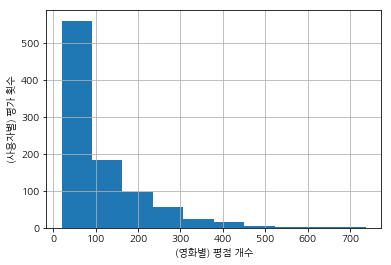

In [9]:
%matplotlib inline
# 시각적 분석결과 Long-tail 분포를 보여준다
# Zip's Law (두번 중요단어는 1/2빈도, 세번 중요단어는 1/3빈도)
from matplotlib import rc
from matplotlib import pyplot as plt
rc('font', family=['NanumGothic','Malgun Gothic'])

# plt.style.use('ggplot') # user_id 별 평가횟수 히스토그램
lens.groupby('user_id').size().sort_values(ascending=False).hist()
plt.xlabel('(영화별) 평점 개수')
plt.ylabel('(사용자별) 평가 횟수')

In [10]:
# 사용자별 평가 횟수와 평점 평균
user_stats = lens.groupby('user_id').agg({'rating': [np.size, np.mean]})
user_stats['rating'].describe()

,size,mean
count,943.000000,943.000000
mean,106.044539,3.588191
std,100.931743,0.445233
min,20.000000,1.491954
25%,33.000000,3.323054
50%,65.000000,3.620690
75%,148.000000,3.869565
max,737.000000,4.869565


## **2 추천 알고리즘과 파라미터**
위에서 분석한 데이터를 기반으로 영화평점을 예측합니다
- 인수분해 머신 알고리즘을 활용합니다
- 행렬 인수분해는 **사용자** 와 **아이템** 만 다루지만, 인수분해머신은 **기타 다양한 특징** 으로도 모델을 만들 수 있습니다
- 로지스틱회귀 모델과 달리, **행렬 인수분해처럼 희소한 행렬** 도 다룰 수 있습니다.
- **특징간의 상호작용** 을 계산에 포함하여 다룹니다
- **Surprise** 모듈의 내용은 [데이터사이언스](https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/) 등을 참고합니다

### **01 fastFM 라이브러리 (factorization machine 알고리즘)**
인수분해 모듈로는 **libFM**이 가장 유명하지만 **C++** 로 구현되어서, 파이선 모듈인 [(**fastFM**)](http://ibayer.github.io/fastFM/tutorial.html#regression-with-als-solver) 을 사용합니다
- **교대 최소제곱법 (ALS):** 예측이 빠르고 SGD에 비해 **파라미터가 적다** // 규제가 필수
- **확률경사하강법 (SGD):** 예측이 빠르고 **대용량에** 적합 // 파라미터가 많고 규제가 필수
- **마르코프 연쇄 몬테카를로 (MCMC):** 하이퍼 파라미터가 적어서 **자동규제** 가능 // 학습이 오래 걸린다

In [11]:
from sklearn.feature_extraction import DictVectorizer
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()       # 피쳐값은 v.feature_names_ 저장
X = v.fit_transform(train) # age값, user BOW(4), item BOW(4) 매트릭스
print(X.toarray())

[[19.  0.  0.  0.  1.  1.  0.  0.  0.]
 [33.  0.  0.  1.  0.  0.  1.  0.  0.]
 [55.  0.  1.  0.  0.  0.  0.  1.  0.]
 [20.  1.  0.  0.  0.  0.  0.  0.  1.]]


In [12]:
# 나이정보를 Integer로 변환 후 모델을 학습합니다
# 실제해와 근사해의 오차가 최소로 되는 모델을 학습
import numpy as np
from fastFM import als
y  = np.array([5.0, 1.0, 2.0, 4.0]) 
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X, y)

# 입력 행렬에는 없지만 모델에서 예측한 3.6 평점을 출력합니다
fm.predict(v.transform({"user": "5", "item": "10", "age": 24}))

array([3.60775939])

### **02 MCMC 모델로 인수분해 학습**
- MovieLens 데이터는 **Train (ua.base)** 과 **Test(ua.test)** 데이터를 분리하여 제공합니다
- 읽은 자료들은 **사용자 ID, 영화 ID 필드를** 더미변수로 정리합니다
- 학습을 위한 파라미터로 **alpha, lambda_w, mu_w** 값을 변화 합니다
- **Q!)** 왜!! 파라미터는 (n_iter-1, 3+2*rank) 인가? **(특히 3, 2는???)**

In [13]:
# Train(모델링/미세조정), Test(훈련모델의 검증) 불러오기
def loadData(filename, path="data/ml-100k/"):
    data, y      = [], []
    users, items = set(), set()
    with open(path + filename) as f:
        for line in f:
            (user, movieid, rating, ts) = line.split('\t')
            data.append({ "user_id": str(user), "movie_id": str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)
    return (data, np.array(y), users, items)

(dev_data,  y_dev,  dev_users,  dev_items)  = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

In [14]:
# Train(dev_data) 을 9:1로 X_train(훈련데이터), X_dev_test(검증데이터) 분할
from sklearn.model_selection import train_test_split
v      = DictVectorizer()
X_dev  = v.fit_transform(dev_data)
X_test = v.transform(test_data)
np.std(y_test)
X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_dev, y_dev, test_size=0.1, random_state=42)

In [15]:
# 모델 및 하이퍼파리미터 초기화
from sklearn.metrics import mean_squared_error
from fastFM import mcmc

n_iter, step_size = 300, 1
seed,   rank      = 123, 4
fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed) # 초기화
fm.fit_predict(X_train, y_train, X_dev_test)
fm

FMRegression(copy_X=True, init_stdev=0.1, n_iter=0, random_state=123, rank=4)

In [16]:
%%time
# hyper_param 학습 파라미터와 RMSE 변화를 저장 
rmse_test   = []
hyper_param = np.zeros((n_iter-1, 3+2*rank), dtype=np.float64)

for nr, i in enumerate(range(1, n_iter)):
    fm.random_state    = i * seed
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_dev_test)))
    hyper_param[nr, :] = fm.hyper_param_

values  = np.arange(1, n_iter)
x       = values * step_size
burn_in = 5
x       = x[burn_in:]
print("학습결과 RMSE 측정값: {:.4f}".format(np.min(rmse_test)))

학습결과 RMSE 측정값: 0.8960
CPU times: user 7.63 s, sys: 4.5 ms, total: 7.63 s
Wall time: 7.64 s


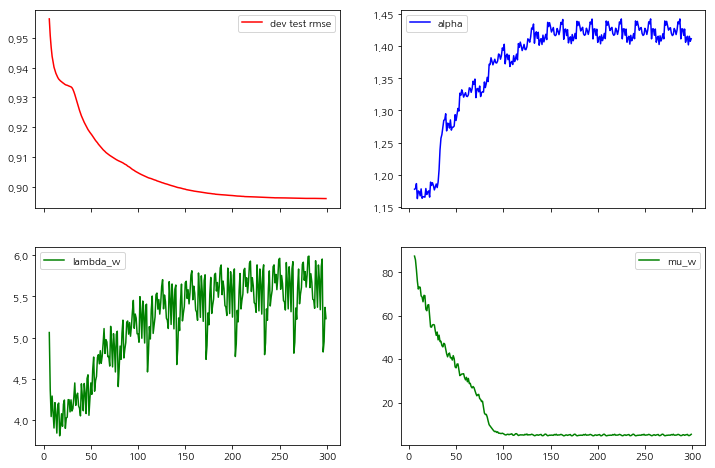

In [17]:
# MCMC 반복에 따른 파라미터 변화 
# 결과분석 : 대략 100번 반복하면 수렴모델이 생성된다
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))
axes[0,0].plot(x, rmse_test[burn_in:],     label='dev test rmse', color="r")
axes[0,1].plot(x, hyper_param[burn_in:,0], label='alpha',         color="b")
axes[1,0].plot(x, hyper_param[burn_in:,1], label='lambda_w',      color="g")
axes[1,1].plot(x, hyper_param[burn_in:,3], label='mu_w',          color="g")
axes[0,0].legend(); axes[0,1].legend(); axes[1,0].legend(); axes[1,1].legend()

### **03 Rank 에 따른 RMSE 변화**
- **rank가** RMSE값에 미치는 영향을 평가해 봅니다
- 시뮬레이션 결과 **rank가 32를 넘으면** RMSE가 크게 줄어듬을 알 수 있습니다

rank:4	rmse:0.903
rank:8	rmse:0.898
rank:16	rmse:0.896
rank:32	rmse:0.893
rank:64	rmse:0.893
시뮬레이션 결과 최소 rmse 값: 0.893
CPU times: user 43.4 s, sys: 118 ms, total: 43.5 s
Wall time: 43.3 s


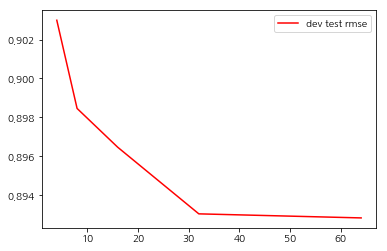

In [18]:
%%time
n_iter, seed, rmse_test = 100, 333, []
ranks = [4, 8, 16, 32, 64]

for rank in ranks:
    fm     = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test)
    rmse   = np.sqrt(mean_squared_error(y_pred, y_dev_test))
    rmse_test.append(rmse)
    print('rank:{}\trmse:{:.3f}'.format(rank, rmse))

plt.plot(ranks, rmse_test, label='dev test rmse', color="r"); plt.legend()
print("시뮬레이션 결과 최소 rmse 값: {:.3f}".format(np.min(rmse_test)))

In [19]:
%%time
# 위에서 학습한 모델을 Test 데이터로 평가합니다
fm     = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
y_pred = fm.fit_predict(X_train, y_train, X_test)
rmse_t = np.sqrt(mean_squared_error(y_pred, y_test))
print("test 데이터 적용결과 rmse: {:4f}".format(rmse_t))

test 데이터 적용결과 rmse: 0.921497
CPU times: user 32.1 s, sys: 220 ms, total: 32.3 s
Wall time: 32.1 s


## **3 추천 알고리즘의 성능 높이기**
### **01 데이터 표준화**
- 훈련데이터에 비해, test 결과값이 낮은건 데이터 분포가 불균질 하기 때문으로 생각된다
- 이를 극복하기 위해 raw_data 를 **표준화(standardization)** 한 후 모델링 합니다
- 표준화 후 학습하는 경우 외부 설정에 따른 민감도가 높아지는걸 볼 수 있습니다

In [20]:
from sklearn.preprocessing import StandardScaler
scaler       = StandardScaler()
y_train_norm = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
fm = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
y_pred = fm.fit_predict(X_train, y_train_norm, X_test)
np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_test))

0.9203443782544464

In [21]:
# 표준화 데이터를 활용하여 반복학습 진행하기
n_iter, rank    = 200, 32
step_size, seed = 1,  123
fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
# 모델 및 하이퍼 파라미터 초기화
fm.fit_predict(X_train, y_train_norm, X_test)

rmse_test, rmse_new = [], []
hyper_param = np.zeros((n_iter -1, 3 + 2 * rank), dtype=np.float64)
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train_norm, X_test, n_more_iter=step_size)
    rmse   = np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_test))
    rmse_test.append(rmse)
    hyper_param[nr, :] = fm.hyper_param_
    if i % 20 == 0:
        print('iter:{:3} rmse:{:.3f}'.format(i, rmse))
print("min rmse: {:.3f}, argmin: {}".format(np.min(rmse_test), x[np.argmin(rmse_test)]))

iter: 20 rmse:0.961
iter: 40 rmse:0.943
iter: 60 rmse:0.932
iter: 80 rmse:0.930
iter:100 rmse:0.930
iter:120 rmse:0.932
iter:140 rmse:0.934
iter:160 rmse:0.936
iter:180 rmse:0.939
min rmse: 0.930, argmin: 96


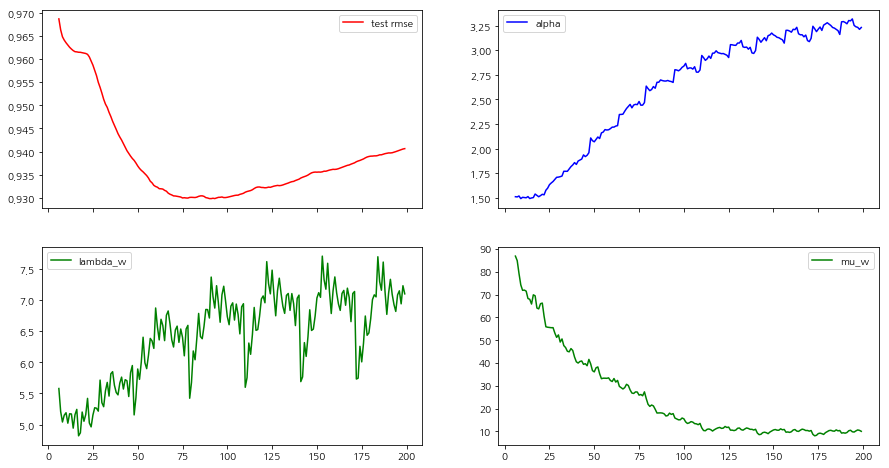

In [22]:
values  = np.arange(1, n_iter)
burn_in = 5
x = values * step_size
x = x[burn_in:]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))
axes[0,0].plot(x, rmse_test[burn_in:], label='test rmse', color="r")
axes[0,1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[1,0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1,1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[0,0].legend(); axes[0,1].legend(); axes[1,0].legend(); axes[1,1].legend()

### **02 상황인지 추천 모델 만들기**
- 사용자와 아이템 이외의 정보를 활용하는 **context-aware recommandation** 모델링
- 개봉연도, 사용자나이, 성별, 평가년도 등 **다양한 필드간의 조합을 활용하여**(인수분해) 모델을 구성합니다
- 즉, **특징값을 다르게 조합해가며** 어떤 효과가 있는지 확인해 본다.
- 실시간 모델링을 원하는 경우 **SGD** 학습을 사용합니다

In [30]:
%%time
lens['user_id']      = lens['user_id'].astype(str)
lens['movie_id']     = lens['movie_id'].astype(str)
lens['year']         = lens['date'].apply(str).str.split('-').str.get(0)
lens['release_year'] = lens['release_date'].apply(str).str.split('-').str.get(2)

rmse_test            = []
n_iter, rank, seed   = 500, 8, 123
candidate_columns    = [
    ['user_id','movie_id', 'release_year', 'age', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'age', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'sex', 'year',  'rating'],
    ['user_id','movie_id', 'age', 'sex', 'rating'],    
    ['user_id','movie_id', 'rating'],
]

# filtered_lens = filtered_lens.astype('float') # 성별등 숫자만 있진 않아서 오류를 발생
import warnings
warnings.simplefilter('ignore')
for column in candidate_columns:
    filtered_lens  = lens[column].dropna() # 누락된 필드들은 제거합니다
    v              = DictVectorizer()
    X_more_feature = v.fit_transform(list(filtered_lens.drop('rating', axis=1).T.to_dict().values()))
    y_more_feature = filtered_lens['rating'].tolist()
    
    # 훈련용/검증용을 9:1 로 분할 후, "y_mf_train" 평점 데이터를 표준화 합니다
    X_mf_train, X_mf_test, y_mf_train, y_mf_test = train_test_split(
        X_more_feature, y_more_feature, test_size=0.1, random_state=42)
    scaler          = StandardScaler() # int64 데이터를 float64로 변환
    y_mf_train_norm = scaler.fit_transform(np.array(y_mf_train).reshape(-1, 1)).ravel()
    fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)

    # 모델 및 하이퍼 파라미터 초기화
    y_pred = fm.fit_predict(X_mf_train, y_mf_train_norm, X_mf_test)
    rmse   = np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred.reshape(-1, 1)), y_mf_test))
    rmse_test.append(rmse)
    print('rmse: {:.3f} 분석목록 {}'.format(rmse,column))

rmse: 0.897 분석필드 목록 ['user_id', 'movie_id', 'release_year', 'age', 'sex', 'year', 'rating']
rmse: 0.894 분석필드 목록 ['user_id', 'movie_id', 'age', 'sex', 'year', 'rating']
rmse: 0.885 분석필드 목록 ['user_id', 'movie_id', 'sex', 'year', 'rating']
rmse: 0.892 분석필드 목록 ['user_id', 'movie_id', 'age', 'sex', 'rating']
rmse: 0.888 분석필드 목록 ['user_id', 'movie_id', 'rating']
CPU times: user 2min 55s, sys: 476 ms, total: 2min 55s
Wall time: 2min 55s


(0.88, 0.9)

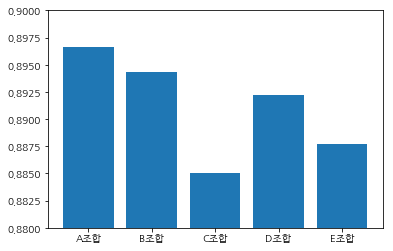

In [31]:
# 분석결과의 시각화
ind = np.arange(len(rmse_test))
bar = plt.bar(ind, height=rmse_test)
plt.xticks(ind, ('A조합', 'B조합', 'C조합', 'D조합', 'E조합'))
plt.ylim((0.88, 0.90))